In [ ]:
#https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

In [115]:
import os
import copy
import shutil
import csv
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import OrderedDict
import random

import scipy as sp
import nlp

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns


import shap
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)

import warnings
warnings.filterwarnings('ignore')

In [2]:

def read_data(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    X = []
    Y = []
    i = 0
    print('Reading articles...')
    for row in read_tsv:
        #print(row)
        # Opening JSON file
        if(row[0][:]!='ID'):

            #if(i%1000==0):
            #    print('Reading article ', i)

            json_file = open('data/jsons/'+row[0][:]+'.json',)
            #print(row[1][:])
            # Reading JSON file
            data = json.load(json_file)

            Y.append(data['bias'])
            X.append(data['content'])


            #print(target)
            #print(text)

            # Closing file
            json_file.close()
            i = i + 1

    tsv_file.close()
    print('done')
    
    return X, Y


In [75]:
print('Load training dataset')
train_data_path = "data/splits/random/train.tsv"
X_train, Y_train = read_data(train_data_path)

# dictionary of lists 
dict_train = {'content': X_train, 'bias': Y_train} 
df_train = pd.DataFrame(dict_train)
#df_train.to_csv('data/splits/media/train_data.tsv', index=False)

print('Load validation dataset')
val_data_path = "data/splits/random/valid.tsv"
X_val, Y_val = read_data(val_data_path)

# dictionary of lists 
dict_val = {'content': X_val, 'bias': Y_val} 
df_val = pd.DataFrame(dict_val)
#df_val.to_csv('data/splits/media/val_data.tsv', index=False)

print('Load test dataset')
test_data_path = "data/splits/random/test.tsv"
X_test, Y_test = read_data(test_data_path)

# dictionary of lists 
dict_test = {'content': X_test, 'bias': Y_test} 
df_test = pd.DataFrame(dict_test)

#df_test.to_csv('data/splits/media/test_data.tsv', index=False)


Load training dataset
Reading articles...
done
Load validation dataset
Reading articles...
done
Load test dataset
Reading articles...
done


In [76]:
train  = df_train[['content', 'bias']] 
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']

val = df_val[['content', 'bias']] 
val.columns = ['DATA_COLUMN', 'LABEL_COLUMN']

test = df_test[['content', 'bias']]
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']

In [116]:
train.head()

DATA_COLUMN  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [79]:
val.head()

DATA_COLUMN  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   President Trump on Monday said he doesn ’ t believe his administration ’ s new report that predicted climate change would shave 10 percent off the U.S. economy by the end of the century .\n“ I don ’ t believe it , ” Mr. Trump said of the dire forecast in the congressionally mandated National Climate Assessment , a scientific report by 13 federal agencies that was released Friday .\nThe report said that potential for losses in some sectors could reach hundreds of billions of dollars per year by the end of this century . It warned that if emissions of heat-trapping gases continue at current levels , labor costs in outdoor industries during heat waves could cost $ 155 billion in lost wages per year by 2090 .\nMr. Trump has weathered criticism for his skepticism about climate science since before he won the White House . He provoked fresh attacks from environmentalists for quietly releasing the 1,656-page report on the day after Thanksgiving .\nJust before the report was released , Mr. Trump pointed to record-low temperatures that had been expected in some parts of the country on Thanksgiving .\n“ Brutal and extended cold blast could shatter all records — whatever happened to global warming ? ” the president wondered on Twitter .\nHowever , the president didn ’ t balk at other findings in the report , including that there was no doubt that human activity contributed to the rising temperatures on Earth 

In [80]:
test.head()

DATA_COLUMN  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minister Benjamin Netanyahu said he no longer would , under any circumstances , endorse the possibility of a Palestinian state .\nHa ’ aretz , a left-wing Israeli newspaper opposing Netanyahu , reported Netanyahu ’ s supposed comment with this headline : “ Netanyahu : If I ’ m Elected , There Will Be No Palestinian State. ” The rest of the media quickly followed . Days later , when Netanyahu said that he had never disavowed his prior support for the possibility of a Palestinian state – support he expressed in a speech at Bar Ilan University in 2009 – the media accused Netanyahu of flip-flopping .\nThere is only one problem : Netanyahu never said that a Palestinian state was out of the question .\nThe interview in which Netanyahu expressed the much-misinterpreted remark took place with the conservative Israeli publication NRG . It also took place in Hebrew , a language virtually none of the members of the Western press read or speak ; most simply took the Ha ’ aretz report and ran with it . Netanyahu was asked directly about whether his Bar-Ilan speech was “ irrelevant. ” Here is what Netanyahu actually said :\nNETANYAHU : I think anyone who is going to build a Palestinian state today will be freeing up space to give an attack area to radical Islam against Israel . This is the reality created here in recent years . Anyone who ignores this sticks his head in the sand . The left does this , burying its head in the sand again and again . We are realistic and understand… NRG : If you are elected head of state , no Palestinian state will come to fruition ? NETANYAHU : Indeed . NRG : Construction in Jerusalem and the West Bank will renew ? NETANYAHU

In [81]:
train.LABEL_COLUMN.value_counts()

2    10240
0     9750
1     7988
Name: LABEL_COLUMN, dtype: int64

In [82]:
label_dict = {'right': 2, 'center': 1, 'left': 0}
label_dict

{'right': 2, 'center': 1, 'left': 0}

In [86]:
tokenizer = BertTokenizer.from_pretrained( #BertTokenizer
    'bert-base-uncased',
    do_lower_case=True
)

In [84]:
max_length = 128

In [87]:
encoded_data_train = tokenizer.batch_encode_plus(
    train.DATA_COLUMN.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val.DATA_COLUMN.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test.DATA_COLUMN.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train.LABEL_COLUMN.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val.LABEL_COLUMN.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test.LABEL_COLUMN.values)

In [88]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

dataset_test = TensorDataset(input_ids_test, 
                              attention_masks_test,
                              labels_test)

In [89]:
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

27978
6996
1300


In [90]:
dataset_val.tensors

(tensor([[  101,  2343,  8398,  ...,  5975,  2071,   102],
         [  101,  1006, 13229,  ...,  1010,  4614,   102],
         [  101,  7511,  9866,  ...,  1996,  2317,   102],
         ...,
         [  101,  2899,  1006,  ...,  1012,  2129,   102],
         [  101,  2044,  1037,  ...,  2005,  2281,   102],
         [  101,  1996,  4450,  ...,  1998, 13712,   102]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([2, 0, 0,  ..., 0, 1, 1]))

In [66]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [91]:
batch_size = 16

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [67]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

In [92]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

In [98]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [99]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [100]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [101]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [69]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [96]:
print(len(dataloader_train))
print(len(dataloader_val))
print(len(dataloader_test))

1749
438
82


In [93]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [38]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]49095690
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1749 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7804814655484984


  0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.6391319493384666
F1 Score (weighted): 0.7164154275474955


Epoch 2:   0%|          | 0/1749 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5726364694062882


  0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.6027836488500306
F1 Score (weighted): 0.7451166800804621


## Training Set Evaluation

In [40]:
train_loss, train_predictions, true_trains = evaluate(dataloader_train)
train_f1 = f1_score_func(train_predictions, true_trains)
print(f'Test loss: {train_loss}')
print(f'Test F1 Score (weighted): {train_f1}')
accuracy_per_class(train_predictions, true_trains)

  0%|          | 0/1749 [00:00<?, ?it/s]

Test loss: 0.4907074200214148
Test F1 Score (weighted): 0.8031065133549401
Class: left
Accuracy:8325/9750

Class: center
Accuracy:5866/7988

Class: right
Accuracy:8294/10240



## Validation Set Evaluation

In [41]:
val_loss, val_predictions, true_vals = evaluate(dataloader_val)
val_f1 = f1_score_func(val_predictions, true_vals)
print(f'Test loss: {val_loss}')
print(f'Test F1 Score (weighted): {val_f1}')
accuracy_per_class(val_predictions, true_vals)

  0%|          | 0/438 [00:00<?, ?it/s]

Test loss: 0.6029245162459269
Test F1 Score (weighted): 0.7451166800804621
Class: left
Accuracy:1931/2438

Class: center
Accuracy:1363/1998

Class: right
Accuracy:1923/2560



## Test Set Evaluation 

In [39]:
test_loss, test_predictions, true_tests = evaluate(dataloader_test)
test_f1 = f1_score_func(test_predictions, true_tests)
print(f'Test loss: {test_loss}')
print(f'Test F1 Score (weighted): {test_f1}')
accuracy_per_class(test_predictions, true_tests)

  0%|          | 0/82 [00:00<?, ?it/s]

Test loss: 0.6778406751591984
Test F1 Score (weighted): 0.7052951796970037
Class: left
Accuracy:280/402

Class: center
Accuracy:278/299

Class: right
Accuracy:364/599



# Explain the model using SHAP

In [110]:
tokenizer = AutoTokenizer.from_pretrained( #BertTokenizer
    'bert-base-uncased',
    do_lower_case=True
)

## Load trained model and predict on test dataset

In [111]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_dict)) #BertForSequenceClassification
model_save_file = os.path.join('./Models/', 'BERT_ft_Epoch2.model')
model.load_state_dict(torch.load(model_save_file))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [112]:
test_loss, test_predictions, true_tests = evaluate(dataloader_test)
test_f1 = f1_score_func(test_predictions, true_tests)
print(f'Test loss: {test_loss}')
print(f'Test F1 Score (weighted): {test_f1}')
accuracy_per_class(test_predictions, true_tests)

  0%|          | 0/82 [00:00<?, ?it/s]

Test loss: 0.6790136078872332
Test F1 Score (weighted): 0.7052951796970037
Class: left
Accuracy:280/402

Class: center
Accuracy:278/299

Class: right
Accuracy:364/599



In [15]:
id2label = {0: 'left', 1: 'center', 2: 'right', 3: 'others'}
labels=list(id2label.values())
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [23]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).to(device)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [24]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [44]:
new_test=test[0:50]
new_test.LABEL_COLUMN.value_counts()

2    26
0    16
1     8
Name: LABEL_COLUMN, dtype: int64

In [42]:
shap_values_multiclass = explainer(test['DATA_COLUMN'][0:50])

Partition explainer: 51it [05:38,  7.05s/it]                                                                           


In [45]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

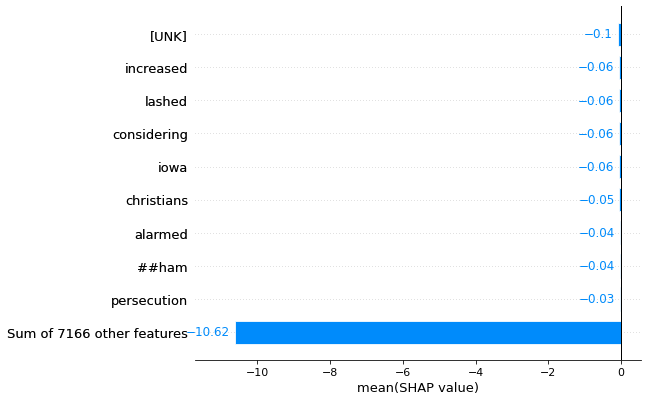

In [47]:
shap.plots.bar(shap_values_multiclass.mean(0)[:,label2id['left']])

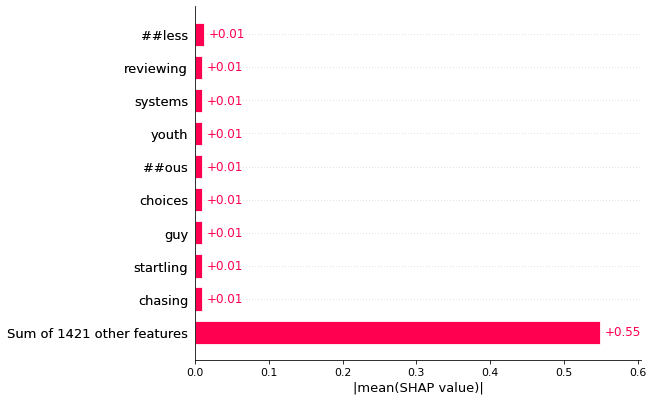

In [48]:
custom_masked_bar_plot(label2id["left"],'pos','mean')

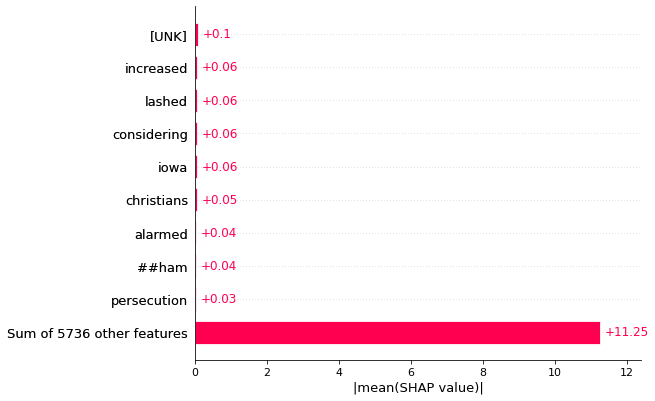

In [49]:
custom_masked_bar_plot(label2id["left"],'neg','mean')

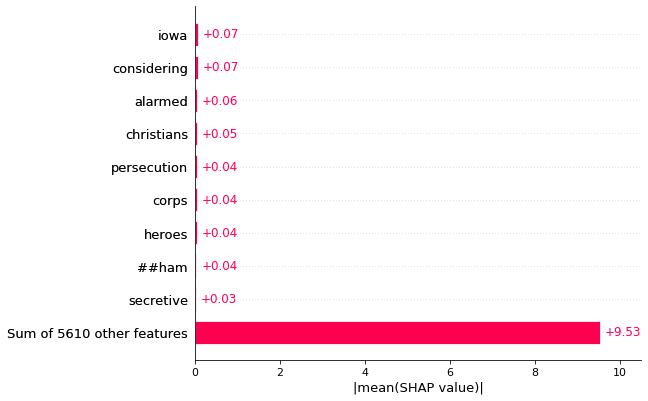

In [50]:
label='right'
custom_masked_bar_plot(label2id[label],'pos','mean')

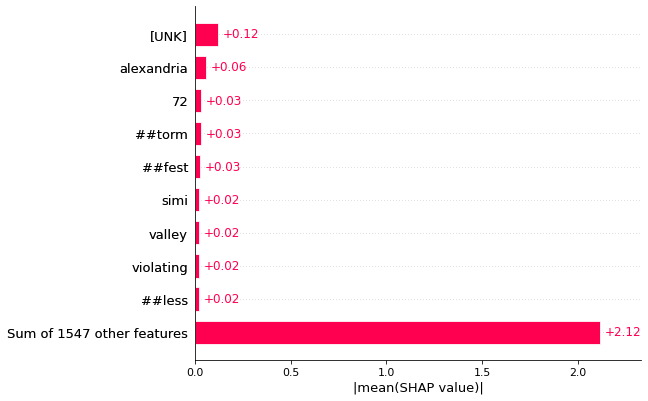

In [51]:
label='right'
custom_masked_bar_plot(label2id[label],'neg','mean')

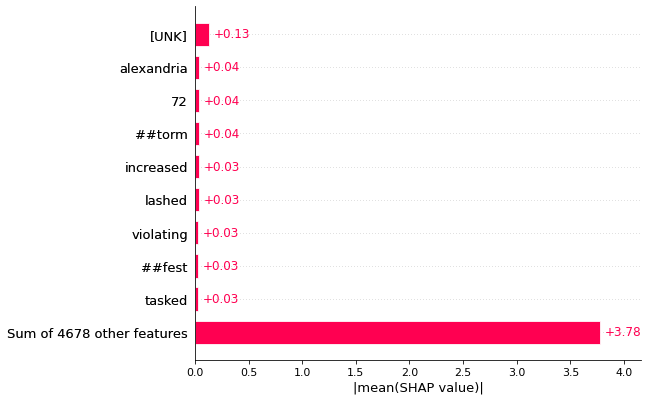

In [64]:
label='center'
custom_masked_bar_plot(label2id[label],'pos','mean')

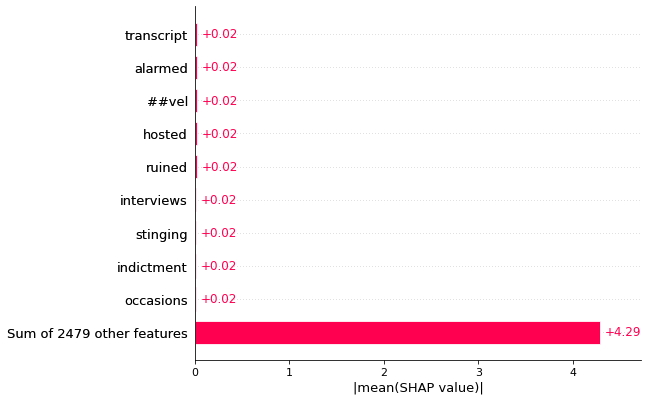

In [65]:
label='center'
custom_masked_bar_plot(label2id[label],'neg','mean')

In [52]:
index = 0
shap.plots.text(shap_values_multiclass[index:index+1])

,,"For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minister Benjamin Netanyahu said he no longer would , under any circumstances , endorse the possibility of a Palestinian state .","Ha ’ aretz , a left-wing Israeli newspaper opposing Netanyahu , reported Netanyahu ’ s supposed comment with this headline : “ Netanyahu : If I ’ m Elected , There Will Be No Palestinian State. ” The rest of the media quickly followed .","Days later , when Netanyahu said that he had never disavowed his prior support for the possibility of a Palestinian state – support he expressed in a speech at Bar Ilan University in 2009 – the media accused Netanyahu of flip-flopping . There is only one problem : Netanyahu never said that a Palestinian state was out of the question . The interview in which Netanyahu expressed the much-misinterpreted remark took place with the conservative Israeli publication NRG .","It also took place in Hebrew , a language virtually none of the members of the Western press read or speak ; most simply took the Ha ’ aretz report and ran with it . Netanyahu was asked directly about whether his Bar-Ilan speech was “ irrelevant. ” Here is what Netanyahu actually said : NETANYAHU : I think anyone who is going to build a Palestinian state today will be freeing up space to give an attack area to radical Islam against Israel .","This is the reality created here in recent years . Anyone who ignores this sticks his head in the sand . The left does this , burying its head in the sand again and again . We are realistic and understand… NRG : If you are elected head of state , no Palestinian state will come to fruition ? NETANYAHU : Indeed . NRG : Construction in Jerusalem and the West Bank will renew ? NETANYAHU : We are continuing all the time , but that ’ s not a question about additional building . There is a real threat that the government of the left will join the international community and do their bidding… . Netanyahu continued by arguing that the left would buy into the “ international initiatives to return to the 1967 borders and divide Jerusalem . ” In other words , Netanyahu did not discount the possibility of a Palestinian state forever . He said that anyone who tries to build a Palestinian state “ hayom ” – “ today ” – would be giving territory to radical Islam . He even added that this was a reality created in recent years . To read that as a wholesale rejection of a Palestinian state is to lie . Which is what Ha ’ aretz did . And the entire lazy and ridiculous world media followed . Netanyahu never flip-flopped , because Netanyahu never flipped . And Netanyahu ’ s policy is the exact same as the policy of the man who created the Oslo Accords , Yitzchak Rabin , who said just one month before his assassination in 1995 , “ We view a permanent solution [ involving ] a Palestinian entity which is less than a state… We will not return to the June 4 , 1967 lines… We committed ourselves before the Knesset not to uproot a single settlement in the framework of the interim agreement , and not to hinder building for natural growth… And first and foremost in our concerns is a united Jerusalem , as the capital of Israel , under Israeli sovereignty . ” Ben Shapiro is Senior Editor-At-Large of","███ and author of the new book , The People vs. Barack Obama : The Criminal Case Against The Obama Administration ( Threshold Editions , June 10 , 2014 ) . He is also Editor-in-Chief of TruthRevolt.org . Follow Ben Shapiro on Twitter @ benshapiro .",
left,-0.0,0.182,-0.031,0.48,0.037,-0.0,-0.0,-0.0
center,0.0,-0.305,-0.292,-0.129,-0.229,0.0,0.0,0.0
right,0.0,0.057,0.251,-0.38,0.229,0.0,0.0,0.0
